# "Transfer learning for a siamese pair model"
> "Give it two pet images and have it predict if they're the same breed."

- categories: [fastai, vision]

In [1]:
#hide
!pip install -Uqq fastai>=2.0.0 graphviz ipywidgets matplotlib nbdev>=0.2.12 pandas scikit_learn azure-cognitiveservices-search-imagesearch sentencepiece

In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
#hide
from fastai.vision.all import *

## Introduction

So far, we've covered all the top-level applications of fastai and the architectures used in the different domains. In the [most recent blog](https://geon-youn.github.io/DunGeon/fastai/2022/05/09/Fine-Tuning.html), we looked into how fastai automatically performs transfer learning for us when we use the application specific `Learner`s like `cnn_learner`. Today, we'll be training a siamese pair model by fine-tuning a pretrained resnet34 architecture without `cnn_learner`. Therefore, we'll have to split the pretrained model ourself and also the data since we won't be using the `DataBlock` API. 

# Preparing the data

Once we download the images, we want a way to organize our data such that we can give it to our model for training.

In [15]:
path  = untar_data(URLs.PETS)
files = get_image_files(path/'images')

In [16]:
#hide
Path.BASE_PATH = path

So, we create a subclass of `fastuple` (fastai's improved `tuple` class) and define a `show` function so that we can actually see it.

In [17]:
class SiameseImage(fastuple): 
    def show(self, ctx=None, **kwargs):
        img1, img2, same_breed = self # (image_like, image_like, bool)
        if not isinstance(img1, Tensor):
            if img2.size != img1.size:
                img2 = img2.resize(img1.size)
            t1, t2 = tensor(img1), tensor(img2)
            t1, t2 = t1.permute(2, 0, 1), t2.permute(2, 0, 1)
        else:
            t1, t2 = img1, img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1, line, t2], dim=2),
                          title=same_breed, ctx=ctx)

Then, we create a label function that'll get the label (pet breed name) from the images. The images are named like `name_numbers.jpg` where spaces in `name` are replaced with underscores. We can get the labels using regex:

In [4]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

The regex expression `^(.*)_\d+.jpg$` means (`^`) from the beginning of the string, (`(.*)`) give me any character repeating zero or more times, (`_\d+.jpg$`) but don't give me the rest off the string, which should look like an underscore followed by a number and a `.jpg` extension. For example,

In [18]:
fname = files[0]; fname

Path('images/scottish_terrier_74.jpg')

In [19]:
label_func(fname)

'scottish_terrier'

And to show how `SiameseImage` works, let's grab two images, give it a `bool` value and show it:

In [25]:
img1, img2 = PILImage.create(files[0]), PILImage.create(files[1])

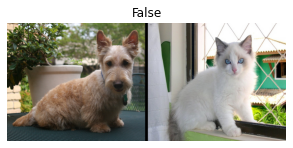

In [26]:
SiameseImage((img1, img2, False)).show();

Next, we have to be able to take all our images and create a training and validation set, which we can do with a `Transform`:

In [ ]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.l_f    = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.f_l    = label_func
        self.valid  = {f: self._draw(f) for f in files[splits[1]]}

    def encodes(self, f):
        f2  , t    = self.valid.get(f, self._draw(f))
        img1, img2 = PILImage.create(f), PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls  = self.f_l(f)
        if not same:
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.l_f[cls]), same

In `SiameseTransform`, we have our `__init__` function that:
- has the labels for all the pet breeds in our data set (`labels`);
- has two functions: one to get a list of all images of the same breed (`l_f`) and one to get the breed from an image (`f_l`); and
- a dictionary that maps a file name to another file name and if they're the same breed (`valid`).

The `encodes` function returns a `SiameseImage` and `_draw` is used to randomly get another image that may or may not be of the same breed.

So, let's create our `DataLoaders` using `SiameseTransorm` alongside `TfmdLists`:

In [ ]:
splits = RandomSplitter()(files)
tfm    = SiameseTransform(files, label_func, splits)
tls    = TfmdLists(files, tfm, splits=splits)
dls    = tls.dataloaders(after_item=[Resize(224), ToTensor],
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

## Preparing the model

For the siamese pair model, we'll take the head off resnet34 to get an encoder. We'll pass the two images to that encoder to get two activations, which we'll concatenate and pass to the head to get two activations that we can use for `CrossEntropyLoss`.

The model will look like this:

In [67]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head

    def forward(self, x1, x2):
        features = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(features)

To get the encoder, we'll get the cut position of resnet34:

In [68]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

And then create the body:

In [70]:
encoder = create_body(resnet34, cut=-2)

The last layer of the encoder has 512 out-channels:

In [71]:
encoder[-1]

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

So, we'll have to create our head with `512 * 2` in-channels since we're passing both images through the encoder and concatenating them:

In [72]:
head = create_head(512 * 2, 2, ps=0.5)

In [73]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

And now we have our model:

In [74]:
model = SiameseModel(encoder, head)

Lastly, we'll have to create two more functions: a loss function and a splitter.

We have to change the current loss function, `CrossEntropyLoss`, because the targets are booleans while our head's output are floats. So, we can change our booleans to numbers:

In [78]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

Then, we have a define a splitter that tells fastai how to split the model into parameter groups which helps the optimizer decide how to apply discriminative learning rates. We'll have two groups: the parameters of the encoder and the parameters of the head:

In [79]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

Finally, we can create our `Learner`:

In [ ]:
learn = Learner(dls, model, loss_func=loss_func,
                splitter=siamese_splitter, metrics=accuracy)

## Training the model

Before training our model, we'll have to freeze it since we want our model's head to be less random before we fine-tune the pretrained weights:

In [ ]:
learn.freeze()

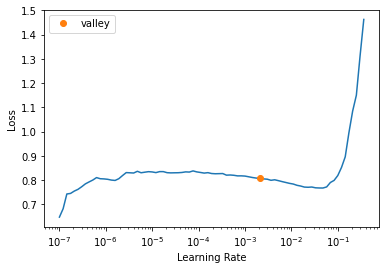

In [ ]:
lr = learn.lr_find().valley

In [ ]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.542693,0.334704,0.853180,01:38
1,0.366947,0.227273,0.915426,01:37
2,0.278382,0.186367,0.928281,01:37
3,0.232669,0.166551,0.937754,01:36


Then, we unfreeze the entire model and train it:

In [ ]:
learn.unfreeze()

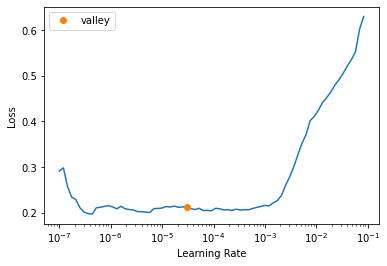

In [ ]:
lrs = learn.lr_find()

In [ ]:
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.212538,0.165287,0.937077,01:42
1,0.231906,0.158641,0.943843,01:42
2,0.210199,0.155071,0.940460,01:41
3,0.215205,0.154223,0.943166,01:40


## Conclusion

Compared to our [last siamese pair](https://geon-youn.github.io/DunGeon/vision/2022/02/21/Pet-Breeds.html), we've simplified the model so that we can directly pass two images and get returned a boolean value representing if they're of the same breed instead of passing two images separately and comparing the output labels. Most importantly, we were able to train a model using fastai's mid-level API and fine-tune resnet34 without the use of `cnn_learner`. 